In [1]:
#Install pgeocode to preprocess 'zip code' column
!pip install pgeocode

In [2]:
#Import Library
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import pgeocode
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

#SMOTE library
from imblearn.over_sampling import SMOTE
#Scaler library
from sklearn.preprocessing import RobustScaler
#tf library
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

#kaggle directory uplaoded from a local file in laptop
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-04-27 21:27:29.112353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 21:27:29.112504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 21:27:29.250060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/bank-loan-granting/Bank_Loan_Granting.csv


#### Binary classification to predict whether a person is granted a personal loan(1) or not(0) using BPNN.

# Preprocessing

In [3]:
#Load dataset
df = pd.read_csv('/kaggle/input/bank-loan-granting/Bank_Loan_Granting.csv')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1


#### There are a few things that need to be preprocessed first so we can analize it later on like "Zip Code" and "CCAvg"

In [4]:
#CCAvg column seems to have an error in formatting, it uses '/' rather than '.' since it is an average value of spending per month.

#Replacing '/' with '.' for 'CCAvg' col
df.CCAvg = df['CCAvg'].str.replace('/','.')

In [5]:
#ZIP Code can be derived to find exactly the latitude and longitude coordinate of a subject using pgeocode library

#first, we need to locate where this data is from, i looked on google for country where the zip codes are 5-digit numbers, looks like it is in the United States

#declare the location to browse the zip codes
location = pgeocode.Nominatim('us')

#Create a list to save the latitude & longitude result
lat = []
long = []

#iterate through each row to browse its latitude & longitude value
for row in df['ZIP Code']:
    res = location.query_postal_code(row)
    lat.append(res['latitude'])
    long.append(res['longitude'])

#Append the result to the main dataframe
df['lat'] = pd.DataFrame(lat)
df['lon'] = pd.DataFrame(long)

#### Initially we can also search for its County & City by Zip codes, but instead i will only use latitude & longitude, since using county & city could lead to potential increase in dimentionality while encoding. 

In [6]:
#Check head again after preprocessed
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard,lat,lon
0,1,25,1,49,91107,4,1.60,1,0,0,1,0,0,0,34.1510,-118.0889
1,2,45,19,34,90089,3,1.50,1,0,0,1,0,0,0,33.7866,-118.2987
2,3,39,15,11,94720,1,1.00,1,0,0,0,0,0,0,37.8738,-122.2549
3,4,35,9,100,94112,1,2.70,2,0,0,0,0,0,0,37.7195,-122.4411
4,5,35,8,45,91330,4,1.00,2,0,0,0,0,0,1,34.2283,-118.5368


# EDA

In [7]:
#Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0000,1250.7500,2500.5000,3750.2500,5000.0000
Age,5000.0,45.338400,11.463166,23.0000,35.0000,45.0000,55.0000,67.0000
Experience,5000.0,20.104600,11.467954,-3.0000,10.0000,20.0000,30.0000,43.0000
Income,5000.0,73.774200,46.033729,8.0000,39.0000,64.0000,98.0000,224.0000
ZIP Code,5000.0,93152.503000,2121.852197,9307.0000,91911.0000,93437.0000,94608.0000,96651.0000
Family,5000.0,2.396400,1.147663,1.0000,1.0000,2.0000,3.0000,4.0000
Education,5000.0,1.881000,0.839869,1.0000,1.0000,2.0000,3.0000,3.0000
Mortgage,5000.0,56.498800,101.713802,0.0000,0.0000,0.0000,101.0000,635.0000
Personal Loan,5000.0,0.096000,0.294621,0.0000,0.0000,0.0000,0.0000,1.0000
Securities Account,5000.0,0.104400,0.305809,0.0000,0.0000,0.0000,0.0000,1.0000


In [8]:
#Check dimension/shape
df.shape

(5000, 16)

In [9]:
#Check column datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   object 
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
 14  lat                 4959 non-null   float64
 15  lon                 4959 non-null   float64
dtypes: flo

#### Looks like we need to cast CCAvg column into numeric(float) so we can process it later.

In [10]:
#casting 'CCAvg' to float
df.CCAvg = df['CCAvg'].astype('float64')

In [11]:
#Check for missing values
df.isna().sum()

ID                     0
Age                    0
Experience             0
Income                 0
ZIP Code               0
Family                 0
CCAvg                  0
Education              0
Mortgage               0
Personal Loan          0
Securities Account     0
CD Account             0
Online                 0
CreditCard             0
lat                   41
lon                   41
dtype: int64

#### Since there are 41 missing value from latitude and longitude columns, assuming there is an error from the pgeocode library, the 41 rows will be dropped.

In [12]:
#Dropping NA
df.dropna( inplace = True)

In [13]:
#Check for anomaly, where experience is less than 0 (can be seen from the descriptive statistic above)
len(df[df['Experience'] < 0])

51

#### There are 51 rows where "Experience" is below 0, we can drop the rows, but it is more preferable to absolute the value, so we don't lose any information from the whole row, since we have already dropped 41 rows before.

In [14]:
#Univariate outlier analysis
num_df = df.select_dtypes(include=['number'])
target = num_df['Personal Loan']
num_df.drop('Personal Loan', axis = 1, inplace = True)
temp_dict = []

for var in num_df:
    q1 = num_df[var].quantile(0.25)
    q3 = num_df[var].quantile(0.75)
    iqr = q3-q1
    
    outliers = num_df[var][((num_df[var] < (q1 - iqr*1.5)) | (num_df[var] > (q3+1.5*iqr)))]
    
    outliers_dict = {'features' : var, 'outlier count' : len(outliers)}
    temp_dict.append(outliers_dict)

uni_outlier_df = pd.DataFrame.from_dict(temp_dict)
print('Univariate outlier analysis :')
uni_outlier_df = uni_outlier_df[uni_outlier_df['outlier count'] > 0]
uni_outlier_df

Univariate outlier analysis :


,features,outlier count
3,Income,96
6,CCAvg,320
8,Mortgage,289
9,Securities Account,516
10,CD Account,302


#### Looks like we have 5 columns where outlier exists, lets try to plot "Income" to see how skewed the column is.

<Axes: xlabel='Income', ylabel='Count'>

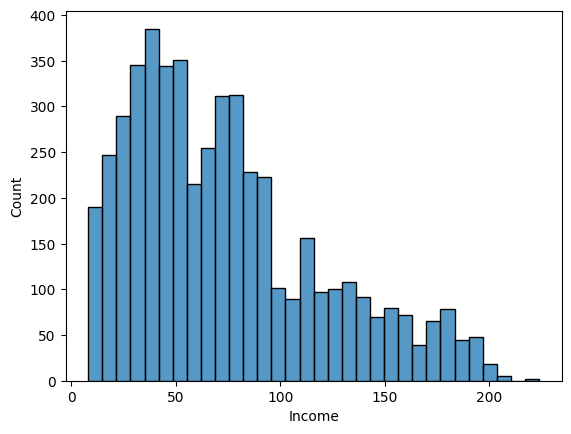

In [15]:
#Looking at "Income" col from the desc statistic above, it could be skewed, because the max is at 224, whie its mean value is at 73.
sns.histplot(df['Income'])

#### As we can see "Income" is skewed right, to handle this and the other columns where outliers exists, we can use robust scaler later on.

In [16]:
#do a simple correlation analysis to check how each variable correlates to the target variable.
correlation_with_target = df.corr()['Personal Loan'].sort_values(ascending=False)

print(correlation_with_target)

Personal Loan         1.000000
Income                0.503362
CCAvg                 0.366079
CD Account            0.317775
Mortgage              0.141417
Education             0.137745
Family                0.060902
Securities Account    0.023476
Online                0.009466
CreditCard            0.003226
lon                  -0.002014
ZIP Code             -0.002104
Experience           -0.005789
lat                  -0.005956
Age                  -0.006165
ID                   -0.023695
Name: Personal Loan, dtype: float64


#### From the result above, we can conclude that the y variable are more dependent "Income", "CCAvg", and "CD Account". few rows have little to no correlation to our y variable, but i won't be dropping it since this is an univariate analysis, there is a potential that if these columns are combined (bi-variate) it could lead to great correlation to the y variable.

<Axes: xlabel='Personal Loan', ylabel='count'>

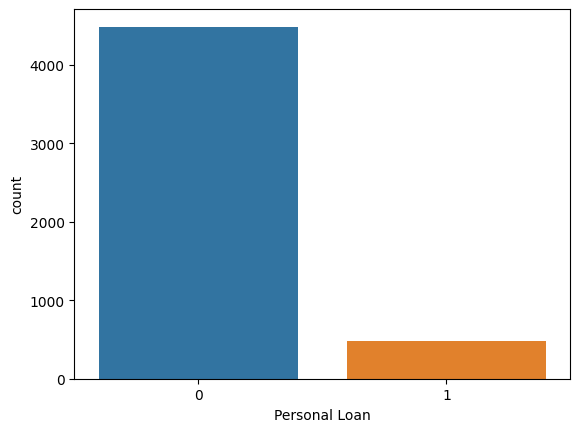

In [17]:
#Lets' check the y variable to see if there is a class imbalance
sns.countplot(x = df['Personal Loan'])

#### The countplot above shows that class '1' and '0' is imbalanced, i would use stratified sampling for this, but in this case, the class is severely imbalanced, so i decided to SMOTE and oversample the minority class(class 1) later on.

# Data Splitting

In [18]:
#Before splitting, lets drop unused columns
df.drop(['ZIP Code','ID'], axis = 1, inplace = True)

In [19]:
#defining X(columns beside target column) and y(target column)
X = df.drop('Personal Loan',axis = 1)
y = df[['Personal Loan']]
#Splitting into train & test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Splitting test set into test & validation set
x_valid, x_test, y_valid, y_test = train_test_split(x_test,y_test, test_size = 0.5)

#### Recap of all the problems so far

#### 1. we need to robust scale our data, since we have lots of outliers
#### 2. we need to oversample class 1, since it is severly lower than class 0 in total. 
#### 3. we need to absolute the value in "Experience", since it is logically impossible to have experience lower than 0
#### 4. we have dropped a few missing longitude and latitude, assuming it is an error from the library that we used.

In [20]:
#absolutting the experience column in all of our sets
x_train.Experience = x_train.Experience.abs()
x_test.Experience = x_test.Experience.abs()
x_valid.Experience = x_valid.Experience.abs()

#### I will oversample the minority class first, before scaling the dataset, because our y variable is severely imbalanced.

In [21]:
#oversampling the minority class
sm = SMOTE(random_state = 42)
x_train, y_train = sm.fit_resample(x_train, y_train)

In [22]:
print(f"Sum of class 1: {len(y_train[y_train == 1])}")
print(f"Sum of class 0: {len(y_train[y_train == 0])}")

Sum of class 1: 7156
Sum of class 0: 7156


In [23]:
#turn y_train back to Series type, after it shifting to array after SMOTE
type(y_train['Personal Loan'])

pandas.core.series.Series

#### Now the class is balanced! we can proceed to scaling our data

In [24]:
#scaling train set predictors using Robust Scaler
scaler = RobustScaler()
cols = x_train.columns
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = cols)
x_train.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,lat,lon
0,-0.947368,-1.052632,-0.765957,-0.5,-0.164754,0.0,0.924370,0.0,0.0,0.0,1.0,-0.389778,0.416500
1,-0.631579,-0.684211,-0.127660,-0.5,0.065977,0.0,1.058824,0.0,0.0,1.0,0.0,0.539567,-0.597897
2,-0.526316,-0.578947,0.308511,0.0,0.659285,0.0,0.000000,0.0,0.0,0.0,0.0,-0.309704,0.161921
3,-0.947368,-0.894737,-0.031915,0.0,0.000054,-1.0,0.000000,0.0,0.0,1.0,0.0,-0.297654,0.172891
4,0.105263,0.052632,-0.670213,0.5,-0.098831,0.0,0.000000,1.0,0.0,0.0,0.0,-0.781283,0.725141


In [25]:
#scaling the rest of the predictors set using Robust Scaler
x_test = pd.DataFrame(scaler.transform(x_test), columns = cols)
x_valid = pd.DataFrame(scaler.transform(x_valid), columns = cols)

In [26]:
#creating a base line model which contains (n, 2*n, 2*n, num_class)
def create_baseline_model(n, num_class):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * n, activation='relu', input_shape=(n,)),
        tf.keras.layers.Dense(2 * n, activation='relu'),
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])
    return model

n = 13  
num_class = 2 

#initialize model
baseline_model = create_baseline_model(n, num_class)
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 26)             │           364 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │           702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,120 (4.38 KB)

 Trainable params: 1,120 (4.38 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#Since we have 2 output layers, but this is a multiclass problem, we need to one hot the y set first so we do not encounter any error
y_train_one_hot = np.eye(num_class)[y_train.squeeze()]
y_valid_one_hot = np.eye(num_class)[y_valid.squeeze()]
y_test_one_hot = np.eye(num_class)[y_test.squeeze()]

In [28]:
#compile the model using binary_crossentropy loss, since it is suitable for binary classification problems.
baseline_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
#implement early stopping to efficiently knows when our model need to be stopped at its' best rate
es = EarlyStopping(patience = 10, restore_best_weights = True, mode = 'max')

In [30]:
#fit and train the model to the train set and validation set
history = baseline_model.fit(x_train, y_train_one_hot, epochs=100, validation_data=(x_valid, y_valid_one_hot), callbacks=[es])

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7093 - loss: 0.5683 - val_accuracy: 0.8831 - val_loss: 0.2898
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9092 - loss: 0.2380 - val_accuracy: 0.9153 - val_loss: 0.1870
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9252 - loss: 0.1753 - val_accuracy: 0.9214 - val_loss: 0.1657
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9385 - loss: 0.1441 - val_accuracy: 0.9456 - val_loss: 0.1408
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9490 - loss: 0.1246 - val_accuracy: 0.9415 - val_loss: 0.1378
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9551 - loss: 0.1126 - val_accuracy: 0.9577 - val_loss: 0.1068
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9529 - loss: 0.1069 - val_accuracy: 0.9476 - val_loss: 0.1206
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9573 - loss: 0.1056 - val_accu

In [31]:
# Predict probabilities for each class for the test set
predicted_probabilities = baseline_model.predict(x_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#use np.argmax to find the highest probability and assign it as our predicted label.
predicted_classes = np.argmax(predicted_probabilities, axis=1)

# evaluation metrics
accuracy = accuracy_score(y_test, predicted_classes)
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f1 = f1_score(y_test, predicted_classes, average='weighted')

# Print evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8487903225806451
Precision: 0.9212677229339922
Recall: 0.8487903225806451
F1 Score: 0.8734229164505228


#### The model generates a good result overall, with precision as it's strongest evaluation score, which mean our model are good at predicting true positives. and the F1 score shows a good result which indicates a good balance between precision and recall.

In [32]:
#reset session to create a new modified model.
tf.keras.backend.clear_session()

# Model Modificattion 

In [33]:
#creating a modified model 
def modified_model(n, num_class):
    modified_model = tf.keras.Sequential([
        tf.keras.layers.Dense(4 * n, activation='relu', input_shape=(n,)),
        tf.keras.layers.Dropout(0.2),  #regularization
        tf.keras.layers.Dense(2 * n, activation='relu'),
        tf.keras.layers.Dropout(0.2),  #regularization
        tf.keras.layers.Dense(2 * n, activation='relu'),
        tf.keras.layers.Dropout(0.2),  #regularization
        tf.keras.layers.Dense(num_class, activation='softmax')
    ])
    return modified_model

#To optimize the model, the complexity is increased to 4 * n units each, while the baseline only have 2 * n units
#Regularization (dropout) is also added to prevent overfitting
#while input remains the same.

n = 13  
num_class = 2 

#initialize model
m_model = modified_model(n, num_class)
m_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 52)             │           728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         1,378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │           702 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,862 (11.18 KB)

 Trainable params: 2,862 (11.18 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
#compiling the model using the same hyperparameters
m_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
#fit and train the model to the train set and validation set
m_history = m_model.fit(x_train, y_train_one_hot, epochs=100, validation_data=(x_valid, y_valid_one_hot), callbacks=[es])

Epoch 1/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7072 - loss: 0.5883 - val_accuracy: 0.8891 - val_loss: 0.2615
Epoch 2/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8991 - loss: 0.2524 - val_accuracy: 0.9355 - val_loss: 0.1729
Epoch 3/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9291 - loss: 0.1856 - val_accuracy: 0.9254 - val_loss: 0.1637
Epoch 4/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9337 - loss: 0.1667 - val_accuracy: 0.9254 - val_loss: 0.1572
Epoch 5/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9374 - loss: 0.1555 - val_accuracy: 0.9375 - val_loss: 0.1477
Epoch 6/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9495 - loss: 0.1348 - val_accuracy: 0.9476 - val_loss: 0.1296
Epoch 7/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9504 - loss: 0.1293 - val_accuracy: 0.9415 - val_loss: 0.1262
Epoch 8/100
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9500 - loss: 0.1263 - val_accu

In [36]:
# Predict probabilities for each class for the test set
modified_predicted_probabilities = m_model.predict(x_test)

#use np.argmax to find the highest probability and assign it as our predicted label.
modified_predicted_classes = np.argmax(modified_predicted_probabilities, axis=1)

# evaluation metrics
accuracy = accuracy_score(y_test, modified_predicted_classes)
precision = precision_score(y_test, modified_predicted_classes, average='weighted')
recall = recall_score(y_test, modified_predicted_classes, average='weighted')
f1 = f1_score(y_test, modified_predicted_classes, average='weighted')

# Print evaluation
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8548387096774194
Precision: 0.9272788860099468
Recall: 0.8548387096774194
F1 Score: 0.8786961386222392


#### Overall, the modified model performs slightly below the baseline_model in all aspects, this means that our modified model, one of the possibilities could be due to overfitting, since the modified model were added more layers/neurons, our modified model could be fitting too closely to the training set, making it bad to predict the test set.

#### Link video penjelasan ; https://drive.google.com/drive/folders/1rQq5SgeiFRYH312JltEJmTNqjDc17vVo?usp=sharing